In [103]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [104]:
path = '../../Dataset/bus/A_2017.11.30_16.48.26.csv.gz'

In [105]:
bus_data = pd.read_csv(path, compression='gzip', low_memory=False)

In [106]:
bus_data.head()

,Timestamp,Longitude,Latitude,Speed,Operatorname,CellID,NetworkMode,RSRP,RSRQ,SNR,CQI,RSSI,DL_bitrate,UL_bitrate,State,NRxRSRP,NRxRSRQ,ServingCell_Lon,ServingCell_Lat,ServingCell_Distance
0,2017.11.30_16.48.26,-8.501373,51.893359,0,A,2,LTE,-102,-12,10.0,7,-85,3,7,D,-,-,-8.491719,51.893905,665.24000000000001
1,2017.11.30_16.48.26,-8.501291,51.893462,1,A,2,LTE,-102,-12,10.0,7,-85,3,7,D,-,-,-8.491719,51.893905,658.67999999999995
2,2017.11.30_16.48.27,-8.501291,51.893462,1,A,2,LTE,-102,-12,7.0,10,-87,310,14,D,-,-,-8.491719,51.893905,658.67999999999995
3,2017.11.30_16.48.28,-8.501291,51.893462,1,A,2,LTE,-102,-12,7.0,7,-85,0,0,I,-,-,-8.491719,51.893905,658.67999999999995
4,2017.11.30_16.48.29,-8.501291,51.893462,1,A,2,LTE,-102,-13,8.0,7,-85,0,0,I,-,-,-8.491719,51.893905,658.67999999999995


In [107]:
bus_data.shape

(910, 20)

In [108]:
bus_data['Timestamp'] = pd.to_datetime(bus_data['Timestamp'], format='%Y.%m.%d_%H.%M.%S')

In [109]:
bus_data['Hour'] = bus_data['Timestamp'].dt.hour

In [110]:
bus_data.isnull().sum()

Timestamp               0
Longitude               0
Latitude                0
Speed                   0
Operatorname            0
CellID                  0
NetworkMode             0
RSRP                    0
RSRQ                    0
SNR                     0
CQI                     0
RSSI                    0
DL_bitrate              0
UL_bitrate              0
State                   0
NRxRSRP                 0
NRxRSRQ                 0
ServingCell_Lon         0
ServingCell_Lat         0
ServingCell_Distance    0
Hour                    0
dtype: int64

In [111]:
features = ['Speed', 'RSRP', 'RSRQ', 'SNR', 'CQI', 'DL_bitrate']

In [133]:
len(features)

6

In [112]:
# Feature engineering: Create moving averages, etc.
bus_data['RSRP_rolling_mean'] = bus_data['RSRP'].rolling(window=5).mean()

In [113]:
bus_data['RSRP_rolling_mean'] = bus_data['RSRP_rolling_mean'].fillna(0)

In [114]:
bus_data.isnull().sum()                                                                                                                                                                                                                        

Timestamp               0
Longitude               0
Latitude                0
Speed                   0
Operatorname            0
CellID                  0
NetworkMode             0
RSRP                    0
RSRQ                    0
SNR                     0
CQI                     0
RSSI                    0
DL_bitrate              0
UL_bitrate              0
State                   0
NRxRSRP                 0
NRxRSRQ                 0
ServingCell_Lon         0
ServingCell_Lat         0
ServingCell_Distance    0
Hour                    0
RSRP_rolling_mean       0
dtype: int64

In [115]:
bus_data.copy()

,Timestamp,Longitude,Latitude,Speed,Operatorname,CellID,NetworkMode,RSRP,RSRQ,SNR,...,DL_bitrate,UL_bitrate,State,NRxRSRP,NRxRSRQ,ServingCell_Lon,ServingCell_Lat,ServingCell_Distance,Hour,RSRP_rolling_mean
0,2017-11-30 16:48:26,-8.501373,51.893359,0,A,2,LTE,-102,-12,10.0,...,3,7,D,-,-,-8.491719,51.893905,665.24000000000001,16,0.0
1,2017-11-30 16:48:26,-8.501291,51.893462,1,A,2,LTE,-102,-12,10.0,...,3,7,D,-,-,-8.491719,51.893905,658.67999999999995,16,0.0
2,2017-11-30 16:48:27,-8.501291,51.893462,1,A,2,LTE,-102,-12,7.0,...,310,14,D,-,-,-8.491719,51.893905,658.67999999999995,16,0.0
3,2017-11-30 16:48:28,-8.501291,51.893462,1,A,2,LTE,-102,-12,7.0,...,0,0,I,-,-,-8.491719,51.893905,658.67999999999995,16,0.0
4,2017-11-30 16:48:29,-8.501291,51.893462,1,A,2,LTE,-102,-13,8.0,...,0,0,I,-,-,-8.491719,51.893905,658.67999999999995,16,-102.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,2017-11-30 17:04:24,-8.556712,51.892251,46,A,1,LTE,-91,-12,3.0,...,7068,128,D,-89.0,-10.0,-8.535593,51.880268,1968.8299999999999,17,-91.8
906,2017-11-30 17:04:25,-8.556712,51.892251,46,A,1,LTE,-91,-12,3.0,...,8992,166,D,-89.0,-10.0,-8.535593,51.880268,1968.8299999999999,17,-91.0
907,2017-11-30 17:04:26,-8.556712,51.892251,46,A,1,LTE,-86,-11,5.0,...,9584,177,D,-85.0,-9.0,-8.535593,51.880268,1968.8299999999999,17,-90.0
908,2017-11-30 17:04:27,-8.556712,51.892251,46,A,1,LTE,-86,-11,5.0,...,11060,198,D,-85.0,-9.0,-8.535593,51.880268,1968.8299999999999,17,-89.0


In [116]:
# Normalize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
bus_data[features] = scaler.fit_transform(bus_data[features])

In [117]:
def create_sequences(bus_data, n_steps):
    X, y = [], []
    for i in range(len(bus_data) - n_steps):
        X.append(bus_data[features].iloc[i:i + n_steps].values)
        y.append(bus_data['DL_bitrate'].iloc[i + n_steps])
    return np.array(X), np.array(y)

# Define sequence length
n_steps = 10
X, y = create_sequences(bus_data, n_steps)

In [118]:
y

array([-8.96547847e-01, -9.88299710e-01, -9.07428156e-01, -8.72919712e-01,
       -9.65564735e-01, -1.01095349e+00, -7.90343036e-01, -9.24722977e-01,
       -8.67479558e-01, -9.11081992e-01, -9.75551885e-01, -9.24722977e-01,
       -1.08817121e+00, -1.01095349e+00, -1.07542338e+00, -1.09271820e+00,
       -1.04359442e+00, -1.00462017e+00, -1.08995753e+00, -1.08183789e+00,
       -1.02004748e+00, -1.04002178e+00, -1.09994468e+00, -1.02370131e+00,
       -1.10083784e+00, -1.08995753e+00, -1.05455592e+00, -1.06730375e+00,
       -1.05000893e+00, -1.04456877e+00, -1.06543623e+00, -1.04732945e+00,
       -1.06543623e+00, -1.09085069e+00, -1.06275675e+00, -1.06275675e+00,
       -1.08817121e+00, -1.09450452e+00, -1.08086354e+00, -1.09085069e+00,
       -1.05276960e+00, -1.08362421e+00, -1.07363706e+00, -1.04091494e+00,
       -1.04635509e+00, -1.08273105e+00, -1.07185074e+00, -1.08817121e+00,
       -1.06730375e+00, -1.09450452e+00, -1.01095349e+00, -1.01736800e+00,
       -1.05366276e+00, -

In [119]:
# Define the model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, len(features))))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

/home/lordmax/.virtualenvs/generalenv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [120]:
# Train the model
model.fit(X, y, epochs=20, batch_size=32)

Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.5941
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3569
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3491
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3110
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2790
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2577
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2465
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2797
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2291
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2508
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2743
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2118
Epoch 13/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2236
Epoch 14/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1900
Epoch 15/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1879
Epoch 16/20
29

In [121]:
# Prediction
predictions = model.predict(X)

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


In [122]:
# Calculate MSE
mse = mean_squared_error(y, predictions)
print(f'MSE: {mse}')

MSE: 0.16060701992793155


In [123]:
# Save predictions to a .npy file
# np.save('../../models/UserDatapredictions.npy', predictions)

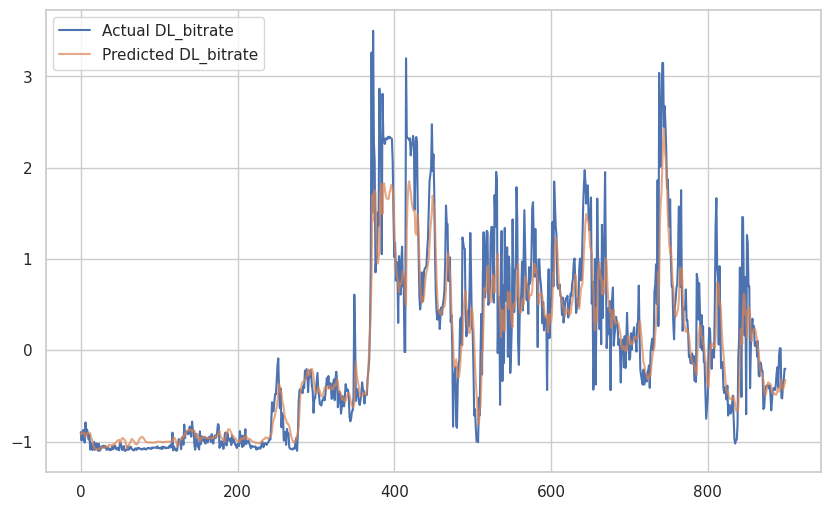

In [124]:
# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y, label='Actual DL_bitrate')
plt.plot(predictions, label='Predicted DL_bitrate', alpha=0.7)
plt.legend()
plt.show()

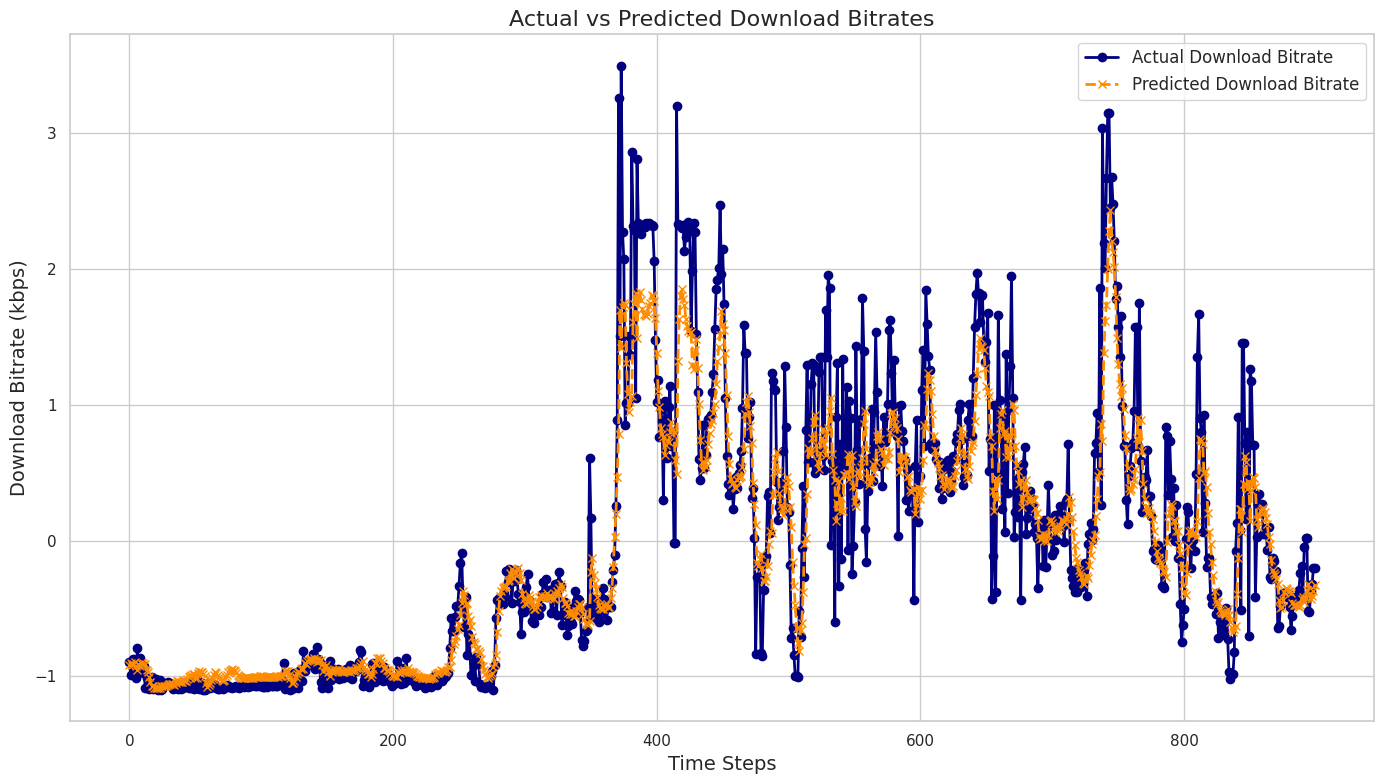

In [125]:
plt.figure(figsize=(14, 8))  # Larger figure size
plt.plot(y, label='Actual Download Bitrate', linewidth=2, marker='o', linestyle='-', color='navy')  # More distinct line
plt.plot(predictions, label='Predicted Download Bitrate', linewidth=2, marker='x', linestyle='--', color='darkorange')  # More distinct line
plt.title('Actual vs Predicted Download Bitrates', fontsize=16)  # Add a title
plt.xlabel('Time Steps', fontsize=14)  # Label x-axis
plt.ylabel('Download Bitrate (kbps)', fontsize=14)  # Label y-axis
plt.legend(loc='upper right', fontsize=12)  # Improve legend readability and position
plt.grid(True)  # Add grid
plt.tight_layout()  # Adjust layout to not cut off content
plt.show()

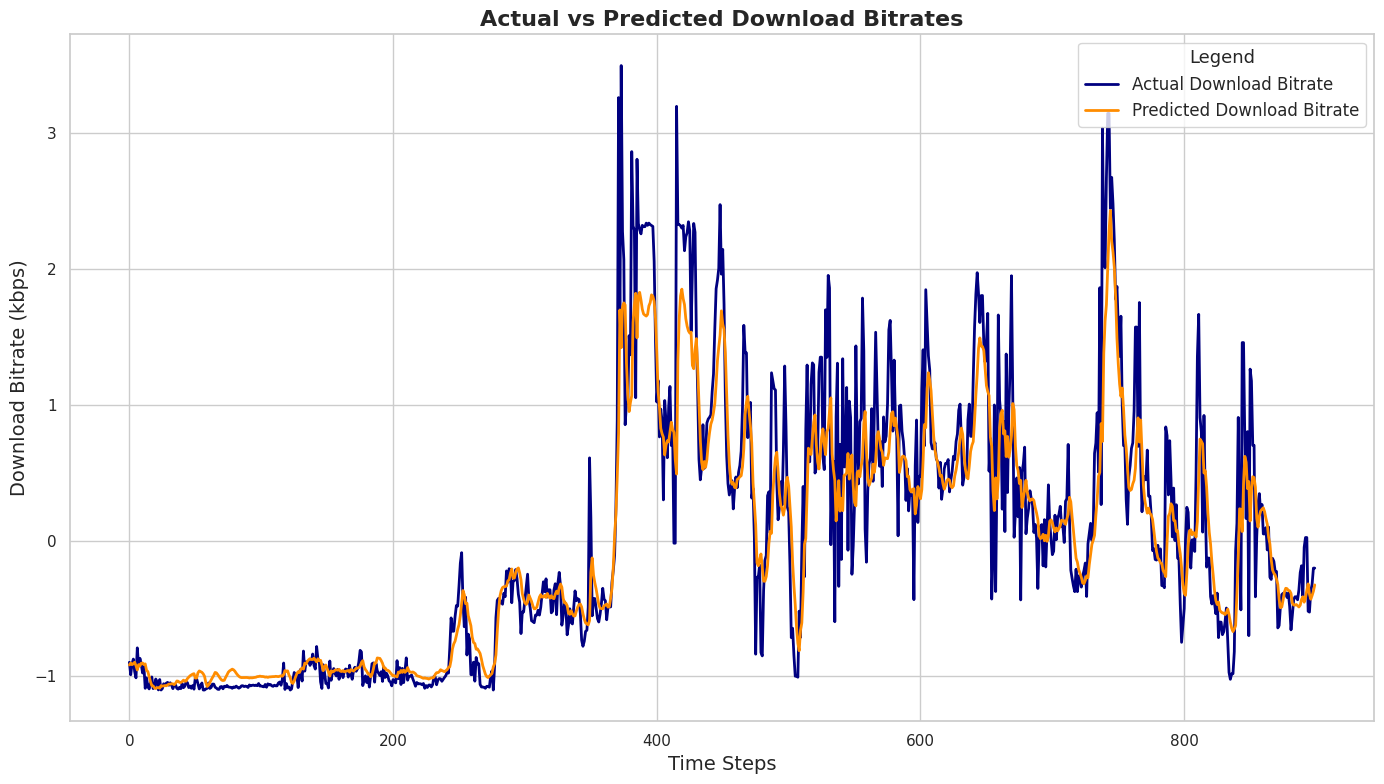

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the Seaborn theme
sns.set_theme(style="whitegrid")

# Create a larger and clearer plot with Seaborn
plt.figure(figsize=(14, 8))

# Plot with simple lines, no markers, smooth style
plt.plot(y, label='Actual Download Bitrate', linewidth=2, linestyle='-', color='navy')
plt.plot(predictions, label='Predicted Download Bitrate', linewidth=2, linestyle='-', color='darkorange')

# Adding enhancements
plt.title('Actual vs Predicted Download Bitrates', fontsize=16, fontweight='bold')
plt.xlabel('Time Steps', fontsize=14)
plt.ylabel('Download Bitrate (kbps)', fontsize=14)
plt.legend(fontsize=12, title='Legend', title_fontsize='13', loc='upper right')
plt.grid(True)  # Ensure grid is visible for better readability
plt.tight_layout()

# Show the plot
plt.show()

# 1. user preferences
Objective: Identify preferences such as frequently accessed services, preferred usage times, and data usage patterns.

In [127]:
bus_data.columns

Index(['Timestamp', 'Longitude', 'Latitude', 'Speed', 'Operatorname', 'CellID',
       'NetworkMode', 'RSRP', 'RSRQ', 'SNR', 'CQI', 'RSSI', 'DL_bitrate',
       'UL_bitrate', 'State', 'NRxRSRP', 'NRxRSRQ', 'ServingCell_Lon',
       'ServingCell_Lat', 'ServingCell_Distance', 'Hour', 'RSRP_rolling_mean'],
      dtype='object')

In [128]:
# Aggregate data by CellID to find frequently accessed cells and preferred hours
cell_usage = bus_data.groupby('CellID').agg({
    'Hour': lambda x: x.value_counts().idxmax(),  # Most frequent hour of usage
    'DL_bitrate': 'sum',  # Total data usage
}).reset_index()

In [129]:
cell_usage.head()

,CellID,Hour,DL_bitrate
0,0,16,48.737009
1,1,16,9.280704
2,2,16,110.823083
3,6,16,-152.659405
4,7,17,-8.671784


# 2. peak usage time

In [130]:
hourly_usage = bus_data.groupby('Hour').agg({
    'DL_bitrate': 'sum',
    'CellID': 'count'
}).reset_index()

In [131]:
# Identify peak usage times
peak_times = hourly_usage.sort_values(by='DL_bitrate', ascending=False).head(10)
print(peak_times)

   Hour  DL_bitrate  CellID
1    17   80.059719     259
0    16  -80.059719     651


# 3. data consumption patterns

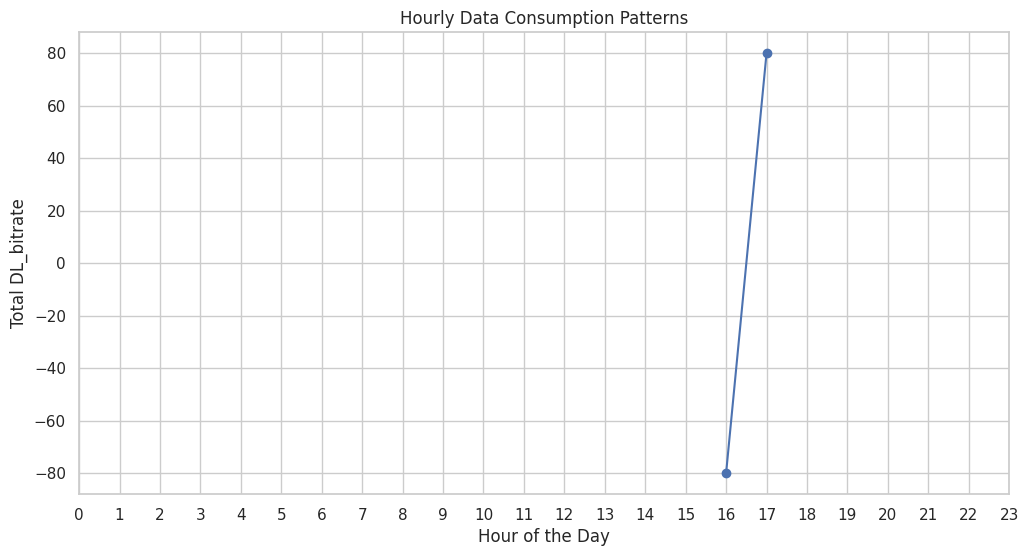

In [132]:
# Plot data consumption patterns
plt.figure(figsize=(12, 6))
plt.plot(hourly_usage['Hour'], hourly_usage['DL_bitrate'], marker='o')
plt.xlabel('Hour of the Day')
plt.ylabel('Total DL_bitrate')
plt.title('Hourly Data Consumption Patterns')
plt.xticks(range(0, 24))  # Ensure all hours are labeled
plt.grid(True)
plt.show()